# Set-up

## Imports

In [102]:
# Standard
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm, trange
import plotly.graph_objects as go

# Sci-kit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, average_precision_score, f1_score, classification_report, matthews_corrcoef, PrecisionRecallDisplay
import joblib

## Parameters

In [120]:
scope = 'OFF'
input_path = f'../data/3_output/ML_dataset_{scope}.pkl'

train_years = [2020]
test_years = [2021]

subsample_size = None

target = 'Result'

features_to_encode = [
    'MargTech',
    'WorkDay',
    'Prov',
    'Tech',
]

other_features = [
    'hour',
    'SC_PC1',
    'SC_PC2',
    'IN_PC1',
    'IN_PC2',
    'CT_PC1',
    'CT_PC2',
    'PurchMGP',
    'SellMGP',
    'MGPprice',
    'GNprice',
    'Price',
    'SolarAngle',
    'DeclAngle',
    'PVold',
    'PVnew',
    'PriceDiff'
]

features = other_features + features_to_encode

## Functions

In [121]:
def test_optimal_threshold(y_probs, y_true, plot=True):
    precision = []
    recall = []
    mcc = []
    accuracy = []
    f1 = []
    thresholds = []

    for threshold in trange(1, 100):

        y_pred = (y_probs >= threshold / 100).astype(bool)

        precision.append(precision_score(y_true, y_pred))
        recall.append(recall_score(y_true, y_pred))
        mcc.append(matthews_corrcoef(y_true, y_pred))
        accuracy.append(accuracy_score(y_true, y_pred))
        f1.append(f1_score(y_true, y_pred))
        thresholds.append(threshold / 100)

    if plot:
        # Plot graph
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=thresholds, y=precision, name="Precision"))
        fig.add_trace(go.Scatter(x=thresholds, y=recall, name="Recall"))
        fig.add_trace(go.Scatter(x=thresholds, y=accuracy, name="Accuracy"))
        fig.add_trace(go.Scatter(x=thresholds, y=mcc, name="Matthews Correlation Coefficient"))
        fig.add_trace(go.Scatter(x=thresholds, y=f1, name="F1-score"))
        fig.update_layout(title="Classification performance scores depending on probability threshold",
                        xaxis_title="Classification level",
                        font=dict(family="Times New Roman, monospace", size=14, color="RebeccaPurple"),
                        template="plotly_white", width=1000, height=700)
        fig.show()

    return precision, recall, mcc, accuracy, f1, thresholds

# Main

## Preprocessing

In [122]:
input_df = pd.read_pickle(input_path)
input_df

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PVold,PVnew,Price,PriceDiff,Result
201801011UP_ALTOADDA_1_OFF,1,20180101,2018,UP_ALTOADDA_1,OFF,1.023687,0.433872,-3.072079,-0.745118,0.717989,...,-178.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.419,False
201801012UP_ALTOADDA_1_OFF,2,20180101,2018,UP_ALTOADDA_1,OFF,0.787333,0.214727,-3.269953,-0.389639,0.717989,...,-163.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.433,False
201801013UP_ALTOADDA_1_OFF,3,20180101,2018,UP_ALTOADDA_1,OFF,1.142582,0.517246,-3.511562,-0.682966,0.717989,...,-148.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.451,False
201801014UP_ALTOADDA_1_OFF,4,20180101,2018,UP_ALTOADDA_1,OFF,1.359091,0.692018,-3.635374,-0.274023,0.717989,...,-133.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.480,False
201801015UP_ALTOADDA_1_OFF,5,20180101,2018,UP_ALTOADDA_1,OFF,1.640151,0.729753,-3.703611,-0.167476,1.093151,...,-118.226106,-23.011637,holiday,Milano,Hydro Run-of-river and poundage,0.000,0.000,111.74,0.513,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022123117UP_VOGHERA_1_OFF,17,20221231,2022,UP_VOGHERA_1,OFF,0.237656,-2.008471,-1.806319,0.875068,-2.527147,...,61.887169,-23.085911,holiday,Pavia,Fossil Gas,0.540,0.540,320.00,0.066,False
2022123121UP_VOGHERA_1_OFF,21,20221231,2022,UP_VOGHERA_1,OFF,-0.075154,-0.954465,-1.872673,0.745683,-2.449869,...,121.887169,-23.085911,holiday,Pavia,Fossil Gas,0.573,0.573,320.00,0.016,False
2022123122UP_VOGHERA_1_OFF,22,20221231,2022,UP_VOGHERA_1,OFF,2.244316,-3.847872,-2.345759,0.833482,-2.547642,...,136.887169,-23.085911,holiday,Pavia,Fossil Gas,0.526,0.526,320.00,0.085,False
2022123123UP_VOGHERA_1_OFF,23,20221231,2022,UP_VOGHERA_1,OFF,2.277886,-3.849805,-2.698679,0.834434,-2.527069,...,151.887169,-23.085911,holiday,Pavia,Fossil Gas,0.525,0.525,320.00,0.190,False


In [123]:
# Subsample
if subsample_size is not None:
    print(f'Subsampled {subsample_size} rows from the input dataset')
    df = input_df.sample(subsample_size)
else:
    df = input_df.copy()

print('Input dataset is composed of {} observations'.format(len(input_df)))
print('{:.1%} bids accepted in the input dataset\n'.format(input_df[target].sum() / len(input_df)))

train_df = df[df.year.isin(train_years)]
print('Training data is composed of {} observations and correspond to years {}'.format(len(train_df), ' '.join([str(year) for year in train_years])))
print('{:.1%} bids accepted in the training data\n'.format(train_df[target].sum() / len(train_df)))

test_df = df[df.year.isin(test_years)]
# test_df.dropna(subset=['PriceDiff'], inplace=True) # HOTFIX
# test_df = test_df[~(test_df == np.inf).any(axis=1)] # HOTFIX
print('Test data is composed of {} observations and correspond to years {}'.format(len(test_df), ' '.join([str(year) for year in test_years])))
print('{:.1%} bids accepted in the test data'.format(test_df[target].sum() / len(test_df)))

Input dataset is composed of 3574411 observations
3.6% bids accepted in the input dataset

Training data is composed of 709486 observations and correspond to years 2020
3.1% bids accepted in the training data

Test data is composed of 666468 observations and correspond to years 2021
3.8% bids accepted in the test data


In [124]:
# We take of the fact that some categories could be absent in the training set but present in the test set
categories = [input_df[feature].unique() for feature in features_to_encode]

feature_transformer = make_column_transformer(
    (OneHotEncoder(categories=categories), features_to_encode),
    remainder="passthrough"
)

X_train = feature_transformer.fit_transform(train_df[features])
y_train = train_df[target]

X_test = feature_transformer.transform(test_df[features])
y_test = test_df[target]

print('Input features are:')
print(feature_transformer.feature_names_in_)

Input features are:
['hour' 'SC_PC1' 'SC_PC2' 'IN_PC1' 'IN_PC2' 'CT_PC1' 'CT_PC2' 'PurchMGP'
 'SellMGP' 'MGPprice' 'GNprice' 'Price' 'SolarAngle' 'DeclAngle' 'PVold'
 'PVnew' 'PriceDiff' 'MargTech' 'WorkDay' 'Prov' 'Tech']


## Model

# Train

In [116]:
%%time

retrain = True
model_path = '{}/model_dumps/model_trained_{}_{}.joblib'.format(scope, scope, '_'.join([str(year) for year in train_years]))

if retrain:
    clf = RandomForestClassifier(
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    # joblib.dump(clf, model_path)
    # print(f'Model saved at {model_path}\n')

else:
    clf = joblib.load(model_path)
    print(f'Model {model_path} loaded\n')


CPU times: user 16min 32s, sys: 5.15 s, total: 16min 37s
Wall time: 1min 42s


## Test

In [117]:
find_threshold = True

y_probs = pd.Series(clf.predict_proba(X_test)[:,1], index=test_df.index)

if find_threshold:
    precision, recall, mcc, accuracy, f1, threshold = test_optimal_threshold(y_probs, y_test)
else:
    print('No threshold search')

  0%|          | 0/99 [00:00<?, ?it/s]

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/guillaume/prometheus/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to cont

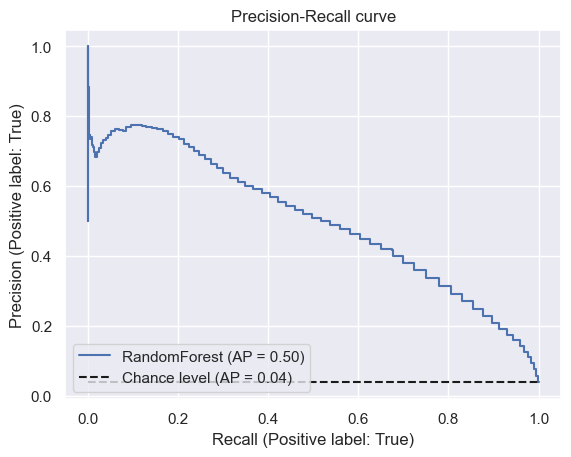

In [118]:
display = PrecisionRecallDisplay.from_estimator(
    clf, X_test, y_test, name="RandomForest", plot_chance_level=True
)
_ = display.ax_.set_title("Precision-Recall curve")

In [119]:
APS = average_precision_score(y_test, y_probs)
print('Average Precision Score over {} samples is: {}'.format(len(y_test), round(APS, 4)))

Average Precision Score over 666468 samples is: 0.5025


# TESTS

In [109]:
test_model = joblib.load('/Users/guillaume/Documents/GitHub/prometheus/modeling/OFF/model_dumps/_old/model_trained_OFF_2020.joblib')

In [111]:
test_model.n_features_in_

67

In [1]:
train_df[train_df.isna().any(axis=1)]

NameError: name 'train_df' is not defined

In [9]:
' '.join([str(year) for year in train_years])

'2018'

In [110]:
feature_transformer.feature_names_in_

array(['hour', 'SC_PC1', 'SC_PC2', 'IN_PC1', 'IN_PC2', 'CT_PC1', 'CT_PC2',
       'PurchMGP', 'SellMGP', 'SolarAngle', 'DeclAngle', 'PV',
       'PriceDiff', 'MargTech', 'WorkDay', 'Prov', 'Tech'], dtype=object)

In [108]:
test_df.columns

Index(['hour', 'date', 'year', 'unit', 'scope', 'SC_PC1', 'SC_PC2', 'IN_PC1',
       'IN_PC2', 'CT_PC1', 'CT_PC2', 'PurchMGP', 'SellMGP', 'MargTech',
       'MGPprice', 'SolarAngle', 'DeclAngle', 'WorkDay', 'Prov', 'Tech', 'PV',
       'Price', 'PriceDiff', 'Result'],
      dtype='object')

In [39]:
test_df[(test_df == np.inf).any(axis=1)]

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,PriceDiff,Result
2020040514UP_BARGI_CEN_1_BID,14,20200405,2020,UP_BARGI_CEN_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.180,1.755045,5.988035,holiday,Bologna,Hydro Pumped Storage,0.498,2.70,inf,False
2020040514UP_BATTIGGIO_1_BID,14,20200405,2020,UP_BATTIGGIO_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.180,1.755045,5.988035,holiday,Verbano-Cusio-Ossola,Hydro Run-of-river and poundage,0.900,0.01,inf,False
2020040514UP_EDOLO_1_BID,14,20200405,2020,UP_EDOLO_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.180,1.755045,5.988035,holiday,Brescia,Hydro Pumped Storage,0.000,2.70,inf,False
2020040514UP_ETQ_ROVINA_1_BID,14,20200405,2020,UP_ETQ_ROVINA_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.180,1.755045,5.988035,holiday,Cuneo,Hydro Pumped Storage,0.000,2.70,inf,False
2020040514UP_MONCALIERI_3_BID,14,20200405,2020,UP_MONCALIERI_3,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.180,1.755045,5.988035,holiday,Torino,Fossil Gas,0.882,2.40,inf,True
2020040514UP_MONCALRPW_2_BID,14,20200405,2020,UP_MONCALRPW_2,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.180,1.755045,5.988035,holiday,Torino,Fossil Gas,1.000,1.00,inf,True
2020040514UP_NCTLVRNFRR_1_BID,14,20200405,2020,UP_NCTLVRNFRR_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.180,1.755045,5.988035,holiday,Vercelli,Fossil Gas,0.411,0.10,inf,True
2020040514UP_S.MASS.CL_1_BID,14,20200405,2020,UP_S.MASS.CL_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.180,1.755045,5.988035,holiday,Trento,Hydro Pumped Storage,0.000,1.00,inf,False
2020040514UP_VALCAMONICA_1_BID,14,20200405,2020,UP_VALCAMONICA_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.180,1.755045,5.988035,holiday,Varese,Hydro Run-of-river and poundage,0.667,0.01,inf,False
2020041214UP_ALTOADDA_1_BID,14,20200412,2020,UP_ALTOADDA_1,BID,6.703662,-2.374222,-0.355219,3.450468,3.309151,...,8.222,2.265306,8.670041,holiday,Milano,Hydro Run-of-river and poundage,0.014,0.01,inf,False


In [29]:
test_df[test_df.isna().any(axis=1)]

,hour,date,year,unit,scope,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,...,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,Price,PriceDiff,Result
2020040514UP_ETQCHIOTAS_1_BID,14,20200405,2020,UP_ETQCHIOTAS_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.18,1.755045,5.988035,holiday,Cuneo,Hydro Pumped Storage,0.000,0.0,NaN,False
2020040514UP_GARGNANO_1_BID,14,20200405,2020,UP_GARGNANO_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.18,1.755045,5.988035,holiday,Brescia,Hydro Pumped Storage,0.000,0.0,NaN,False
2020040514UP_GRAVEDONA_1_BID,14,20200405,2020,UP_GRAVEDONA_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.18,1.755045,5.988035,holiday,Como,Hydro Run-of-river and poundage,0.920,0.0,NaN,False
2020040514UP_LIRO_1_BID,14,20200405,2020,UP_LIRO_1,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.18,1.755045,5.988035,holiday,Sondrio,Hydro Water Reservoir,0.175,0.0,NaN,False
2020040514UP_PNTVENTOUX_3_BID,14,20200405,2020,UP_PNTVENTOUX_3,BID,3.671653,-0.994358,-0.377782,4.200096,3.309151,...,9.18,1.755045,5.988035,holiday,Torino,Hydro Run-of-river and poundage,0.000,0.0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020041314UP_TELESSIO_1_BID,14,20200413,2020,UP_TELESSIO_1,BID,3.518346,-1.917090,-0.764068,3.562065,3.309151,...,8.30,2.333351,9.043807,weekday,Torino,Hydro Pumped Storage,0.000,0.0,NaN,False
2020041315UP_TELESSIO_1_BID,15,20200413,2020,UP_TELESSIO_1,BID,3.273531,-2.131391,-0.953850,3.285568,3.309151,...,8.30,17.333351,9.043807,weekday,Torino,Hydro Pumped Storage,0.000,0.0,NaN,False
2020041313UP_TORINONORD_1_BID,13,20200413,2020,UP_TORINONORD_1,BID,3.316139,-2.119732,-0.617597,3.534228,3.309151,...,8.30,-12.666649,9.043807,weekday,Torino,Fossil Gas,0.943,0.0,NaN,True
2020041314UP_TURBIGO_4_BID,14,20200413,2020,UP_TURBIGO_4,BID,3.518346,-1.917090,-0.764068,3.562065,3.309151,...,8.30,2.333351,9.043807,weekday,Milano,Fossil Gas,0.361,0.0,NaN,True


In [18]:
X_test

<394157x67 sparse matrix of type '<class 'numpy.float64'>'
	with 7037076 stored elements in Compressed Sparse Row format>

In [10]:
input_df.Result.value_counts(normalize=True)

Result
False    0.84069
True     0.15931
Name: proportion, dtype: float64

In [9]:
import sklearn
print(sklearn.__version__)

1.3.2


In [6]:
X_train

,hour,SC_PC1,SC_PC2,IN_PC1,IN_PC2,CT_PC1,CT_PC2,PurchMGP,SellMGP,MargTech,GNprice,SolarAngle,DeclAngle,WorkDay,Prov,Tech,PV,PriceDiff
2018051119UP_VALPELLIN_1_BID,19,-1.249933,0.056897,1.106645,-1.155926,1.730459,-1.922671,21257.008,19108.388,Oliocarbone,22.864,78.431875,17.782271,weekday,Aosta,Hydro Water Reservoir,0.513,-0.863
201902035UP_ROSONE_1_BID,5,-1.466077,0.449724,-2.894275,-0.243380,-1.736063,1.235026,12848.499,7796.231,Ccgt,21.159,-120.888800,-16.969453,holiday,Torino,Hydro Water Reservoir,0.566,-0.756
201904131UP_ETQ_ROVINA_1_BID,1,-1.332986,0.103480,-1.710924,0.022593,-1.142245,1.750112,14812.541,11354.196,Ccgt,20.180,-192.734694,8.670041,holiday,Cuneo,Hydro Pumped Storage,0.000,-1.000
201910105UP_VADOTERM_5_BID,5,-0.973908,-0.421994,-2.312267,-0.220269,-1.733768,1.423223,15001.749,11161.384,Ccgt,15.091,-129.162715,-7.724629,weekday,Savona,Fossil Gas,0.643,-0.268
2019032010UP_ETQ_ROVINA_1_BID,10,0.340353,0.383130,2.355593,0.970641,1.749196,-0.320324,24406.751,19177.641,Ccgt,18.153,-44.578645,-0.807187,weekday,Cuneo,Hydro Pumped Storage,0.000,-1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018070722UP_EDOLO_1_BID,22,-1.470274,-0.296321,0.052143,-2.806381,1.618120,-1.639258,18091.657,16030.631,Ccgt,24.398,121.354734,22.593384,holiday,Brescia,Hydro Pumped Storage,0.000,-0.121
2019042418UP_BARGI_CEN_1_BID,18,0.109658,-0.244600,1.044694,0.424411,1.626718,1.706035,19585.711,16778.972,Carbone,18.224,62.922471,12.616221,weekday,Bologna,Hydro Pumped Storage,0.000,-1.000
2019060312UP_LEVANTE_4_BID,12,-0.756212,0.453766,2.922231,1.199788,1.634402,-1.599583,21244.681,16599.884,Ccgt,14.829,-26.956975,22.302275,weekday,Venezia,Fossil Gas,0.337,-0.508
2019060111UP_CHIEVOLIS_2_BID,11,-0.452494,0.105185,1.033424,1.310162,2.131361,-0.744443,16437.662,13035.047,Estero,13.859,-41.880983,22.039625,holiday,Pordenone,Hydro Water Reservoir,0.633,-1.000


In [16]:
input_df.columns.to_list()

['hour',
 'date',
 'year',
 'unit',
 'scope',
 'SC_PC1',
 'SC_PC2',
 'IN_PC1',
 'IN_PC2',
 'CT_PC1',
 'CT_PC2',
 'PurchMGP',
 'SellMGP',
 'MargTech',
 'MGPprice',
 'GNprice',
 'SolarAngle',
 'DeclAngle',
 'WorkDay',
 'Prov',
 'Tech',
 'PV',
 'Price',
 'PriceDiff',
 'Result']

In [14]:
input_df.MargTech.value_counts()

MargTech
Ccgt             1033415
MC                415162
I.Modulazione     158294
Carbone           154570
I.Fluente         153445
Oliocarbone        76176
Estero             67997
I.Pompaggio        65983
Altro              25478
Fer                20370
Tg                  5105
Olio                1297
Name: count, dtype: int64